# PROJET PHASE 2 - Notebook General

## Version finale


## Environnement
Les dependances sont installees via le fichier `requirements_phase2.txt` avant l'execution des notebooks.

# ETAPE 0 - Cadrage metier

Problème métier
À Lomé, on veut estimer la consommation annuelle d’énergie et les émissions de CO₂ des bâtiments non résidentiels qui n’ont pas de mesure détaillée, pour mieux cibler les actions d’efficacité énergétique.

Type de tâche

Apprentissage supervisé

Régression (on prédit des valeurs numériques continues : kBtu, tonnes CO₂).

Variables cibles envisagées

Cible énergie : SiteEnergyUse(kBtu)

Cible CO₂ : TotalGHGEmissions

Décision concrète prise avec le modèle (exemples réalistes)

Prioriser quels bâtiments doivent être audités ou rénovés en priorité (ceux avec conso/CO₂ très élevés prédits).

Estimer l’impact potentiel de travaux (isolation, changement de système) en comparant avant/après prédiction.

Donner à la ville/aux décideurs une estimation globale des émissions du parc non résidentiel, même sans mesures complètes.

Métriques importantes
Pour chaque cible (énergie et CO₂) :

RMSE (Root Mean Squared Error) :

Avantage : pénalise fort les grosses erreurs → important quand on veut éviter de sous-estimer un bâtiment très consommateur.

MAE (Mean Absolute Error) :

Avantage : plus interprétable (“erreur moyenne ≈ X kBtu ou X tonnes de CO₂”).

R² en plus, pour donner une idée de la proportion de variance expliquée (mais ce n’est pas la métrique principale).

## ETAPE 1 - Chargement et cadrage des donnees


In [3]:
# importation des packages 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Pour que tes graphiques s'affichent bien dans VS Code
%matplotlib inline

In [4]:
# Afficher beaucoup de lignes et colonnes
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)

# Pour éviter le retour à la ligne automatique
pd.set_option('display.width', 2000)

# Afficher les colonnes complètes
pd.set_option('display.max_colwidth', None)

In [5]:
from pathlib import Path

csv_path = Path("2016_Building_Energy_Benchmarking.csv")
df = pd.read_csv(csv_path)

print("Dataset charge depuis:", csv_path.resolve())
df.head()


Dataset charge depuis: C:\Users\DELL WORKSTATION\OneDrive\DCLIC\projet_phase_2\2016_Building_Energy_Benchmarking.csv


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   str    
 3   PrimaryPropertyType              3376 non-null   str    
 4   PropertyName                     3376 non-null   str    
 5   Address                          3376 non-null   str    
 6   City                             3376 non-null   str    
 7   State                            3376 non-null   str    
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   str    
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   str    
 12  Latitude                       

In [7]:
import pandas as pd

info_complet = pd.DataFrame({
    "type": df.dtypes,
    "non_null": df.count(),
    "null": df.isna().sum(),
    "null_%": (df.isna().sum() / len(df)) * 100,
    "unique": df.nunique()
})

info_complet

,type,non_null,null,null_%,unique
OSEBuildingID,int64,3376,0,0.000000,3376
DataYear,int64,3376,0,0.000000,1
BuildingType,str,3376,0,0.000000,8
PrimaryPropertyType,str,3376,0,0.000000,24
PropertyName,str,3376,0,0.000000,3362
Address,str,3376,0,0.000000,3354
City,str,3376,0,0.000000,1
State,str,3376,0,0.000000,1
ZipCode,float64,3360,16,0.473934,55
TaxParcelIdentificationNumber,str,3376,0,0.000000,3268


In [8]:
# STEP 1 — Doublons (toutes colonnes) : résultat numérique
print("duplicates (all columns):", df.duplicated().sum())


duplicates (all columns): 0


## ETAPE 2 - Definition des 2 cibles


In [9]:
# Definissons les noms des colonnes cibles
target_energy = "SiteEnergyUse(kBtu)"

target_co2 = "TotalGHGEmissions"

In [10]:
# Stat de base et valeur manquante de ma cible
df[[target_energy, target_co2]].describe(), df[[target_energy, target_co2]].isna().sum()

(       SiteEnergyUse(kBtu)  TotalGHGEmissions
 count         3.371000e+03        3367.000000
 mean          5.403667e+06         119.723971
 std           2.161063e+07         538.832227
 min           0.000000e+00          -0.800000
 25%           9.251286e+05           9.495000
 50%           1.803753e+06          33.920000
 75%           4.222455e+06          93.940000
 max           8.739237e+08       16870.980000,
 SiteEnergyUse(kBtu)    5
 TotalGHGEmissions      9
 dtype: int64)

In [11]:
# ETAPE 2.2 — Définir X brut (en enlevant seulement les cibles)
X = df.drop(columns=[target_energy, target_co2])

print("X shape:", X.shape)
print("Colonnes de X (aperçu):", X.columns.tolist())


X shape: (3376, 44)
Colonnes de X (aperçu): ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier', 'GHGEmissionsIntensity']


In [12]:
# ETAPE 2.3 — Séparer les colonnes par type
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "string", "category"]).columns.tolist()



In [13]:
print("Nb colonnes numériques:", len(num_cols))
print("Nb colonnes catégorielles:", len(cat_cols))
print("\nNumériques (aperçu):", num_cols[:10])
print("\nCatégorielles (aperçu):", cat_cols[:10])


Nb colonnes numériques: 28
Nb colonnes catégorielles: 15

Numériques (aperçu): ['OSEBuildingID', 'DataYear', 'ZipCode', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']

Catégorielles (aperçu): ['BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'TaxParcelIdentificationNumber', 'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']


In [14]:

# ETAPE 2.4 — Colonnes techniques (IDs / texte libre)
technical_cols = [
    "OSEBuildingID",
    "PropertyName",
    "Address",
    "TaxParcelIdentificationNumber"
]

[col for col in technical_cols if col in X.columns]


['OSEBuildingID', 'PropertyName', 'Address', 'TaxParcelIdentificationNumber']

## ETAPE 3 - Analyse univariee


In [15]:
# ETAPE 3.1 — EDA univariée des cibles (stats + quantiles)
df[[target_energy, target_co2]].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])


,SiteEnergyUse(kBtu),TotalGHGEmissions
count,3.371000e+03,3367.000000
mean,5.403667e+06,119.723971
std,2.161063e+07,538.832227
min,0.000000e+00,-0.800000
1%,1.171529e+05,1.306000
5%,4.918200e+05,3.780000
50%,1.803753e+06,33.920000
95%,1.816162e+07,392.797000
99%,5.394861e+07,1176.714000
max,8.739237e+08,16870.980000


La plupart des bâtiments sont en dessous de quelques dizaines de millions,

Mais il existe quelques bâtiments extrêmes avec des valeurs énormes → forte asymétrie (skew à droite) + gros outliers.

Beaucoup de bâtiments autour de quelques dizaines / centaines,

Quelques bâtiments qui explosent les valeurs → outliers très forts,

Un CO₂ négatif → probablement une erreur ou un codage spécial.

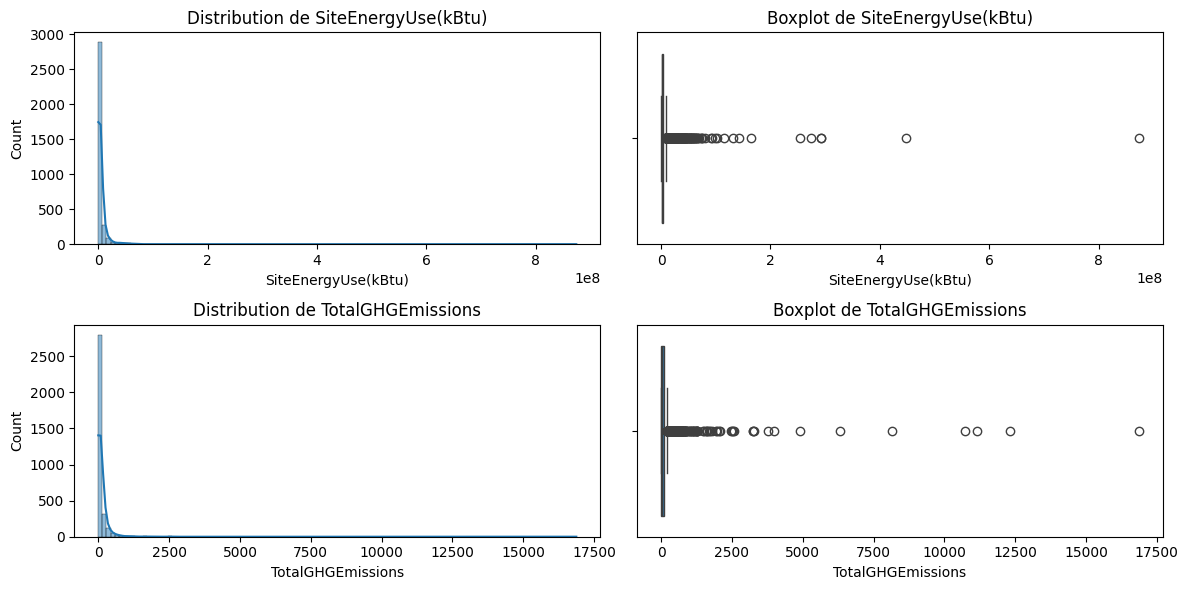

In [16]:
# On crée une figure avec deux lignes (une pour chaque cible)
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Visualisation pour l'Énergie
sns.histplot(df[target_energy], kde=True, ax=axes[0, 0])
axes[0, 0].set_title(f'Distribution de {target_energy}')

sns.boxplot(x=df[target_energy], ax=axes[0, 1])
axes[0, 1].set_title(f'Boxplot de {target_energy}')

# Visualisation pour le CO2
sns.histplot(df[target_co2], kde=True, ax=axes[1, 0])
axes[1, 0].set_title(f'Distribution de {target_co2}')

sns.boxplot(x=df[target_co2], ax=axes[1, 1])
axes[1, 1].set_title(f'Boxplot de {target_co2}')

plt.tight_layout()
plt.show()

La distribution est très asymétrique (skew à droite) avec quelques bâtiments qui consomment énormément (peut-être très grands complexes ou erreurs de mesure). Si on laisse ces valeurs telles quelles, elles vont fortement influencer les modèles et les métriques sensibles aux grosses erreurs (RMSE).

Conclusion pour le CO₂ :
Distribution également très skew à droite, avec quelques bâtiments qui émettent énormément et au moins une valeur aberrante (CO₂ négatif). Là aussi, les outliers vont peser très fort dans l’apprentissage si on ne les gère pas correctement.

In [17]:
# ETAPE 3.1.b — Qualité des cibles : NA, zéros, négatifs

print("NA sur les cibles :")
print(df[[target_energy, target_co2]].isna().sum())

print("\nValeurs spéciales :")
print("  Energie == 0 :", (df[target_energy] == 0).sum())
print("  CO2 < 0      :", (df[target_co2] < 0).sum())


NA sur les cibles :
SiteEnergyUse(kBtu)    5
TotalGHGEmissions      9
dtype: int64

Valeurs spéciales :
  Energie == 0 : 18
  CO2 < 0      : 1


Le CO₂ négatif est presque sûrement une valeur fausse / codage particulier (physiquement, on ne peut pas avoir des émissions négatives comme ça).

Les 18 énergies = 0 : ce sont probablement des bâtiments où soit :

la mesure n’a pas été faite / mal enregistrée,

soit le bâtiment était vide / hors service,

soit le zéro sert de valeur par défaut.

In [18]:
num_focus = ["PropertyGFATotal", "NumberofFloors"]
df[num_focus].describe(percentiles = [0.01, 0.05, 0.5, 0.95, 0.99])

,PropertyGFATotal,NumberofFloors
count,3.376000e+03,3376.000000
mean,9.483354e+04,4.709123
std,2.188376e+05,5.494465
min,1.128500e+04,0.000000
1%,2.014375e+04,1.000000
5%,2.129150e+04,1.000000
50%,4.417500e+04,4.000000
95%,3.200960e+05,12.000000
99%,7.554350e+05,31.000000
max,9.320156e+06,99.000000


La plupart des bâtiments sont “normaux” (entre ~20k et quelques centaines de milliers de pieds²).

Mais il existe quelques bâtiments énormes (plusieurs millions) → ça crée une distribution très asymétrique avec de gros outliers.

Ça colle bien avec un parc réel : petits bâtiments + quelques très gros complexes.

La majorité des bâtiments ont entre 1 et 12 étages (bureaux, hôtels, etc.).

Quelques tours très hautes (jusqu’à 99 étages) → encore des outliers.

Le min = 0 est un peu bizarre (peut être du parking, un rez-de-chaussée codé 0, ou une anomalie).

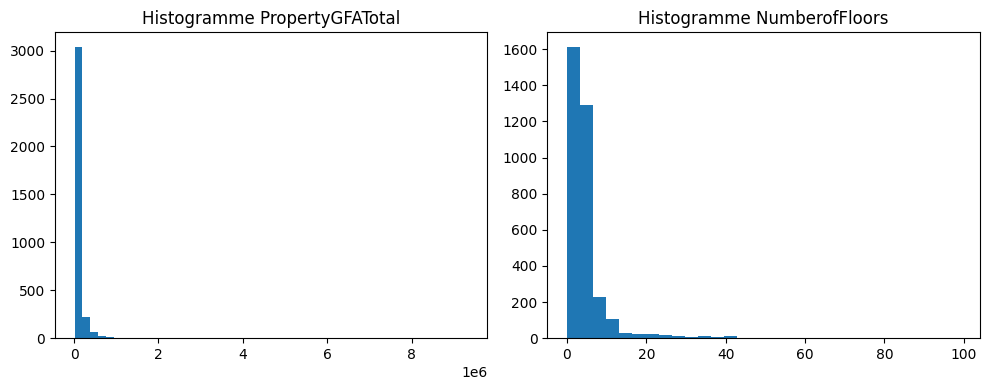

In [19]:
# ETAPE 3.2b — Histogrammes de PropertyGFATotal et NumberofFloors

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df["PropertyGFATotal"], bins=50)
axes[0].set_title("Histogramme PropertyGFATotal")

axes[1].hist(df["NumberofFloors"], bins=30)
axes[1].set_title("Histogramme NumberofFloors")

plt.tight_layout()
plt.show()


In [20]:
# ETAPE 3.3a — Corrélation simple avec la cible énergie

corr_energy = df[[target_energy, "PropertyGFATotal", "NumberofFloors"]].corr()[target_energy]
print(corr_energy)


SiteEnergyUse(kBtu)    1.000000
PropertyGFATotal       0.796781
NumberofFloors         0.205864
Name: SiteEnergyUse(kBtu), dtype: float64


PropertyGFATotal ~ 0.80 → corrélation fortement positive avec l’énergie.

NumberofFloors ~ 0.21 → corrélation faible à modérée : plus d’étages aide un peu à expliquer l’énergie, mais beaucoup moins que la surface totale.

In [21]:
# ETAPE 3.3b — Energie moyenne par type de bâtiment

mean_energy_by_type = (
    df.groupby("BuildingType")[target_energy]
      .mean()
      .sort_values(ascending=False)
)
print(mean_energy_by_type)


BuildingType
Campus                  8.128178e+07
Multifamily HR (10+)    9.559329e+06
NonResidential          7.743262e+06
Nonresidential COS      5.964288e+06
Nonresidential WA       3.180819e+06
SPS-District K-12       3.132788e+06
Multifamily MR (5-9)    2.900916e+06
Multifamily LR (1-4)    1.403062e+06
Name: SiteEnergyUse(kBtu), dtype: float64


In [22]:
# ETAPE 3.4a — Corrélation simple avec la cible CO2

corr_co2 = df[[target_co2, "PropertyGFATotal", "NumberofFloors", target_energy]].corr()[target_co2]
print(corr_co2)


TotalGHGEmissions      1.000000
PropertyGFATotal       0.531436
NumberofFloors         0.136014
SiteEnergyUse(kBtu)    0.862668
Name: TotalGHGEmissions, dtype: float64


In [23]:
# ETAPE 3.4b — CO2 moyen par type de bâtiment

mean_co2_by_type = (
    df.groupby("BuildingType")[target_co2]
      .mean()
      .sort_values(ascending=False)
)
print(mean_co2_by_type)


BuildingType
Campus                  1859.234583
Multifamily HR (10+)     255.173818
NonResidential           166.340947
Nonresidential COS       139.082824
SPS-District K-12         93.618163
Multifamily MR (5-9)      66.376345
Multifamily LR (1-4)      28.068932
Nonresidential WA         22.170000
Name: TotalGHGEmissions, dtype: float64


In [24]:
# ETAPE 3.5 — Répartition des types de bâtiments (catégorielles)

for col in ["BuildingType", "PrimaryPropertyType"]:
    print("\n====", col, "====")
    print(df[col].value_counts(normalize=True).head(10))



==== BuildingType ====
BuildingType
NonResidential          0.432464
Multifamily LR (1-4)    0.301540
Multifamily MR (5-9)    0.171801
Multifamily HR (10+)    0.032583
SPS-District K-12       0.029028
Nonresidential COS      0.025178
Campus                  0.007109
Nonresidential WA       0.000296
Name: proportion, dtype: float64

==== PrimaryPropertyType ====
PrimaryPropertyType
Low-Rise Multifamily           0.292358
Mid-Rise Multifamily           0.167062
Small- and Mid-Sized Office    0.086789
Other                          0.075829
Warehouse                      0.055391
Large Office                   0.051244
K-12 School                    0.041173
Mixed Use Property             0.039396
High-Rise Multifamily          0.031102
Retail Store                   0.026955
Name: proportion, dtype: float64


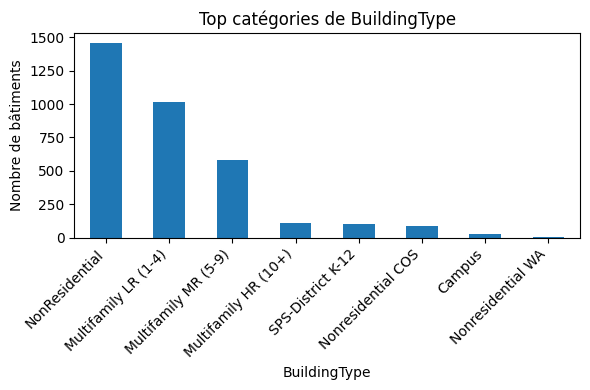

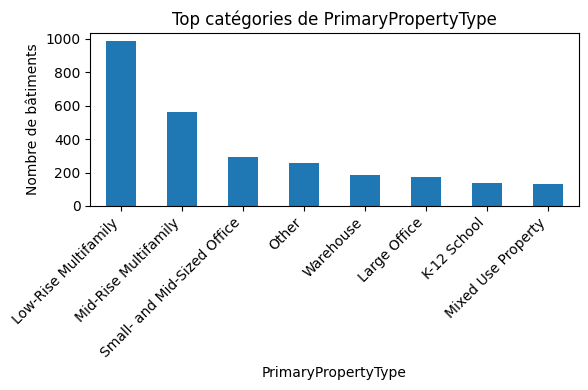

In [25]:
# ETAPE 3.5 — Barplots des catégories principales

import matplotlib.pyplot as plt

cols = ["BuildingType", "PrimaryPropertyType"]

for col in cols:
    top = df[col].value_counts().head(8)  # top 8 catégories
    plt.figure(figsize=(6, 4))
    top.plot(kind="bar")
    plt.title(f"Top catégories de {col}")
    plt.ylabel("Nombre de bâtiments")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


NonResidential domine clairement : c’est la barre la plus haute, autour de ~1000 bâtiments.

Ensuite viennent surtout les multifamiliaux : Multifamily LR (1–4), Multifamily MR (5–9), puis Multifamily HR (10+).

Les autres types (SPS-District K-12, Nonresidential COS, Campus, Nonresidential

On voit une grosse barre pour Low-Rise Multifamily, puis Mid-Rise Multifamily, puis Small- and Mid-Sized Office.

Les autres (Other, Warehouse, Large Office, K-12 School, Mixed Use Property, …) ont des effectifs plus faibles.

Donc là aussi, il y a quelques catégories dominantes et un long “tail” de catégories plus petites.

## ETAPE 4 - Correlations entre variables numeriques


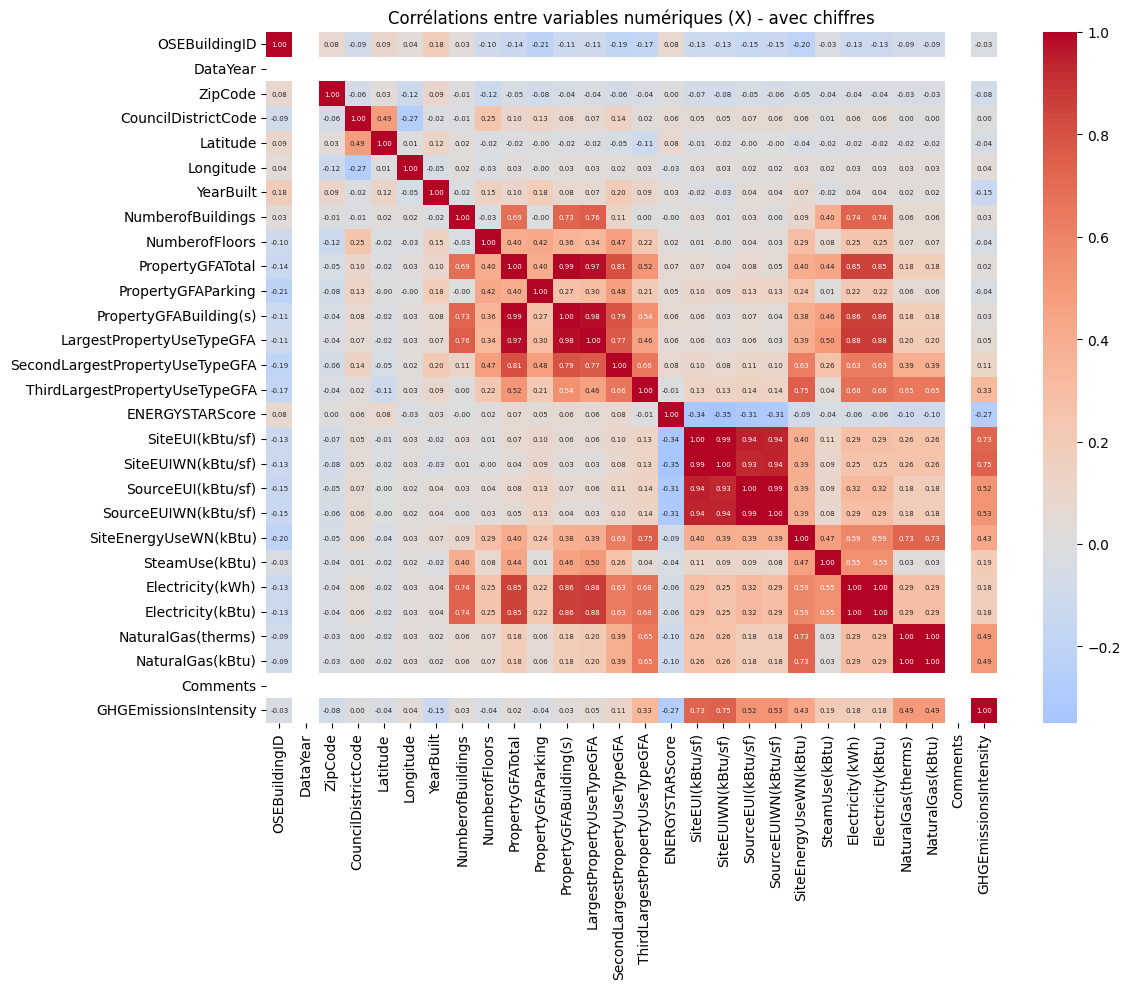

In [26]:
# ETAPE 4 — Heatmap corrélations (toutes les numériques) AVEC CHIFFRES

import seaborn as sns
import matplotlib.pyplot as plt

corr_num = X[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_num,
    cmap="coolwarm",
    center=0,
    annot=True,       # affiche les chiffres
    fmt=".2f",        # 2 décimales
    annot_kws={"fontsize": 5}  # petite police pour que ça tienne
)
plt.title("Corrélations entre variables numériques (X) - avec chiffres")
plt.tight_layout()
plt.show()



In [27]:
# ETAPE 4.1 — Paires fortement corrélées (|corr| >= 0.8)

import numpy as np

corr = X[num_cols].corr().abs()  # corrélation en valeur absolue
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_pairs = upper.stack().sort_values(ascending=False)

print(high_pairs[high_pairs >= 0.8])


Electricity(kWh)           Electricity(kBtu)                  1.000000
NaturalGas(therms)         NaturalGas(kBtu)                   1.000000
SourceEUI(kBtu/sf)         SourceEUIWN(kBtu/sf)               0.994317
SiteEUI(kBtu/sf)           SiteEUIWN(kBtu/sf)                 0.993549
PropertyGFATotal           PropertyGFABuilding(s)             0.989823
PropertyGFABuilding(s)     LargestPropertyUseTypeGFA          0.978422
PropertyGFATotal           LargestPropertyUseTypeGFA          0.974113
SiteEUI(kBtu/sf)           SourceEUI(kBtu/sf)                 0.944141
                           SourceEUIWN(kBtu/sf)               0.940204
SiteEUIWN(kBtu/sf)         SourceEUIWN(kBtu/sf)               0.938051
                           SourceEUI(kBtu/sf)                 0.930434
LargestPropertyUseTypeGFA  Electricity(kWh)                   0.875059
                           Electricity(kBtu)                  0.875059
PropertyGFABuilding(s)     Electricity(kWh)                   0.859833
      

## ETAPE 5 - Nettoyage et imputations


In [28]:
# ETAPE 5.1 — Nettoyage des lignes selon la qualité des cibles

df_clean = df.copy()

before = df_clean.shape

mask_valid = (
    df_clean[target_energy].notna() &
    df_clean[target_co2].notna() &
    (df_clean[target_energy] > 0) &
    (df_clean[target_co2] >= 0)
)

df_clean = df_clean[mask_valid].copy()

after = df_clean.shape

print("shape avant :", before, "| shape après :", after)

print("\nContrôle cibles dans df_clean :")
print(df_clean[[target_energy, target_co2]].isna().sum())
print("Energie == 0 :", (df_clean[target_energy] == 0).sum())
print("CO2 < 0      :", (df_clean[target_co2] < 0).sum())


shape avant : (3376, 46) | shape après : (3348, 46)

Contrôle cibles dans df_clean :
SiteEnergyUse(kBtu)    0
TotalGHGEmissions      0
dtype: int64
Energie == 0 : 0
CO2 < 0      : 0


In [29]:
# ETAPE 5.2 — Taux de NA des features (df_clean, sans les cibles)

na_rate = (
    df_clean.drop(columns=[target_energy, target_co2])
            .isna()
            .mean()
            .sort_values(ascending=False)
)

print(na_rate.head(15))


Comments                           1.000000
Outlier                            0.990442
YearsENERGYSTARCertified           0.964755
ThirdLargestPropertyUseType        0.821983
ThirdLargestPropertyUseTypeGFA     0.821983
SecondLargestPropertyUseType       0.499104
SecondLargestPropertyUseTypeGFA    0.499104
ENERGYSTARScore                    0.244026
ZipCode                            0.004779
LargestPropertyUseTypeGFA          0.003286
LargestPropertyUseType             0.003286
SiteEUIWN(kBtu/sf)                 0.000299
SiteEnergyUseWN(kBtu)              0.000299
Neighborhood                       0.000000
TaxParcelIdentificationNumber      0.000000
dtype: float64


Colonnes à supprimer (trop de NA, peu de valeur)

Comments → 100% NA → aucune information exploitable

Outlier → 99% NA → colonne quasi vide, impossible à utiliser proprement

YearsENERGYSTARCertified → 96% NA → presque aucun bâtiment avec cette info

ThirdLargestPropertyUseType → 82% NA

ThirdLargestPropertyUseTypeGFA → 82% NA

Les 2 colonnes “SecondLargest…” sont à 49.9% → borderline.
👉 On choisit de les garder pour l’instant (elles pourront être imputées plus tard), car elles sont juste en dessous du seuil 0.5 que tu as fixé dans ton plan.

In [30]:
# ETAPE 5.3 - Suppression des colonnes trop manquantes

cols_drop_missing = [
    "Comments",
    "Outlier",
    "YearsENERGYSTARCertified",
    "ThirdLargestPropertyUseType",
    "ThirdLargestPropertyUseTypeGFA",
]

before_cols = df_clean.shape[1]
df_clean = df_clean.drop(columns=cols_drop_missing)
after_cols = df_clean.shape[1]

print("Nb colonnes avant :", before_cols, "| apr?s :", after_cols)
print("Colonnes encore presentes (controle) :", [c for c in cols_drop_missing if c in df_clean.columns])


Nb colonnes avant : 46 | après : 41
Colonnes encore présentes (vérif) : []


In [31]:
cols_drop_missing = [
    "Comments",
    "Outlier",
    "YearsENERGYSTARCertified",
    "ThirdLargestPropertyUseType",
    "ThirdLargestPropertyUseTypeGFA",
]


In [32]:
# ETAPE 5.3b - Controle des colonnes presentes/apres suppression

cols_drop_missing = [
    "Comments",
    "Outlier",
    "YearsENERGYSTARCertified",
    "ThirdLargestPropertyUseType",
    "ThirdLargestPropertyUseTypeGFA",
]

present = [c for c in cols_drop_missing if c in df_clean.columns]
missing = [c for c in cols_drop_missing if c not in df_clean.columns]

print("Presentes dans df_clean :", present)
print("Deja absentes        :", missing)


Présentes dans df_clean : []
Déjà absentes          : ['Comments', 'Outlier', 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']


In [33]:
# ETAPE 5.3c - Verification de l'etat de df_clean apres nettoyage des cibles

print("df_clean shape:", df_clean.shape)
print("Colonnes df_clean (apercu):", df_clean.columns.tolist())


df_clean shape: (3348, 41)
Colonnes df_clean (aperçu): ['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'City', 'State', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [34]:
# ETAPE 5.4 — Taux de NA restants dans df_clean (hors cibles)

na_rate_clean = (
    df_clean.drop(columns=[target_energy, target_co2])
            .isna()
            .mean()
            .sort_values(ascending=False)
)

print(na_rate_clean.head(10))


SecondLargestPropertyUseTypeGFA    0.499104
SecondLargestPropertyUseType       0.499104
ENERGYSTARScore                    0.244026
ZipCode                            0.004779
LargestPropertyUseTypeGFA          0.003286
LargestPropertyUseType             0.003286
SiteEUIWN(kBtu/sf)                 0.000299
SiteEnergyUseWN(kBtu)              0.000299
City                               0.000000
PropertyName                       0.000000
dtype: float64


### Strategie de nettoyage et imputation

**Objectif de cette étape**

- Garantir que le modèle apprenne sur des **labels cohérents** (énergie, CO₂) ;
- Réduire au minimum l’impact des **valeurs manquantes** sur les features ;
- Éviter toute **fuite d’information** liée aux variables qui sont déjà des mesures d’énergie ou de CO₂.

---

#### 5.1. Nettoyage des lignes (cibles `y`)

Pour l’entraînement des modèles, on ne garde que les bâtiments pour lesquels les deux cibles sont fiables :

- `SiteEnergyUse(kBtu)` : non nulle et **strictement > 0**  
- `TotalGHGEmissions` : non null et **≥ 0**

Tout bâtiment avec :
- énergie manquante, énergie = 0,
- CO₂ manquant ou CO₂ < 0

est retiré du dataset de modélisation.

> Raison : un modèle de régression supervisée ne peut pas apprendre correctement si les labels sont impossibles (CO₂ négatif) ou clairement non mesurés (énergie = 0 pour un bâtiment non résidentiel).

---

#### 5.2. Colonnes supprimées ou exclues des features

**Colonnes supprimées car inutilisables :**

- `Comments` (≈ 100 % NA)
- `Outlier` (≈ 99 % NA)
- `YearsENERGYSTARCertified` (≈ 96 % NA)
- `ThirdLargestPropertyUseType`, `ThirdLargestPropertyUseTypeGFA` (≈ 82 % NA)

Ces variables sont trop manquantes pour être exploitées dans une baseline simple.

**Colonnes exclues des features pour éviter la fuite de données :**

- Variables d’énergie dérivées ou normalisées, par exemple :
  - `SiteEnergyUseWN(kBtu)`
  - `SiteEUIWN(kBtu/sf)`
  - `SourceEUI(kBtu/sf)`, `SourceEUIWN(kBtu/sf)`
- Ces colonnes sont directement calculées à partir de la consommation d’énergie et de la surface : les utiliser pour prédire l’énergie ou le CO₂ reviendrait à donner au modèle une information qu’il est censé reconstituer.

**Colonnes exclues pour simplicité / faible valeur ajoutée :**

- `ZipCode`  
  → considéré comme un code administratif peu explicatif dans ce contexte, la localisation étant déjà portée par `Latitude` / `Longitude`.

---

#### 5.3. Stratégie d’imputation des features

L’imputation sera réalisée **dans le pipeline scikit-learn**, après le découpage train/test, pour éviter toute fuite d’information.  
On distingue :

- un cas **particulier** (second usage du bâtiment),
- les variables **numériques** en général (dont `ENERGYSTARScore`),
- les variables **catégorielles**.

---

##### 5.3.1. Cas particulier : second usage du bâtiment

Variables concernées (~50 % de valeurs manquantes) :

- `SecondLargestPropertyUseType` (catégorielle)
- `SecondLargestPropertyUseTypeGFA` (numérique)

Stratégie :

1. Création d’une feature binaire :

   - `HasSecondProperty` = 1 si `SecondLargestPropertyUseType` est non nulle, 0 sinon.  
   > L’absence de deuxième usage est considérée comme une information en soi.

2. Surface du deuxième usage :

   - `SecondLargestPropertyUseTypeGFA` : les valeurs manquantes seront mises à **0** (pas de deuxième usage), en combinaison avec le flag `HasSecondProperty`.

3. Type de deuxième usage :

   - `SecondLargestPropertyUseType` : imputation par une catégorie explicite, par exemple `"Unknown"` ou `"None"`.

---

##### 5.3.2. Variables numériques (dont `ENERGYSTARScore`)

- Exemple de variables : `ENERGYSTARScore`, `LargestPropertyUseTypeGFA`, etc.
- Méthode d’imputation prévue : **`KNNImputer`** (k voisin le plus proche) appliqué aux features numériques dans le `ColumnTransformer`.

> Idée : estimer la valeur manquante en se basant sur des bâtiments “similaires” (surface, âge, type de propriété, etc.), ce qui est plus riche qu’une simple moyenne/médiane.

Les colonnes numériques sans valeurs manquantes ne sont pas modifiées par l’imputeur (il ne touche qu’aux NA).

---

##### 5.3.3. Variables catégorielles

- Exemple de variables : `BuildingType`, `PrimaryPropertyType`, `LargestPropertyUseType`, `SecondLargestPropertyUseType`, etc.
- Méthode d’imputation :

  - **`SimpleImputer(strategy="most_frequent")`** pour la majorité des variables catégorielles ;
  - Pour certaines colonnes, une catégorie explicite `"Unknown"` / `"Missing"` est utilisée (ex. `SecondLargestPropertyUseType`).

Ensuite, les variables catégorielles seront encodées via **One-Hot Encoding** dans le pipeline de prétraitement.

---

#### 5.4. Résumé

- Les labels (`SiteEnergyUse(kBtu)`, `TotalGHGEmissions`) sont nettoyés pour ne garder que des valeurs physiquement plausibles.
- Les colonnes vides ou quasi vides sont supprimées.
- Les variables directement dérivées de l’énergie / CO₂ sont exclues pour éviter la fuite.
- Les valeurs manquantes sur les features sont gérées par :
  - une combinaison de **feature engineering simple** (`HasSecondProperty` + 0 GFA),
  - **KNNImputer pour les numériques**,
  - **SimpleImputer (mode ou `"Unknown"`) pour les catégorielles**,
  le tout **intégré dans un pipeline scikit-learn**.



## ETAPE 6 - Feature engineering


In [35]:
# ETAPE 6.1 — Feature engineering sur le 2e usage

df_fe = df_clean.copy()

# 1) Flag : y a-t-il un second usage ?
df_fe["HasSecondProperty"] = df_fe["SecondLargestPropertyUseType"].notna().astype(int)

# 2) Mise à 0 de la surface du 2e usage quand elle est manquante
na_before = df_fe["SecondLargestPropertyUseTypeGFA"].isna().sum()
df_fe["SecondLargestPropertyUseTypeGFA"] = df_fe["SecondLargestPropertyUseTypeGFA"].fillna(0)
na_after = df_fe["SecondLargestPropertyUseTypeGFA"].isna().sum()

print("shape df_fe:", df_fe.shape)
print("HasSecondProperty value_counts():")
print(df_fe["HasSecondProperty"].value_counts())

print("\nNA SecondLargestPropertyUseTypeGFA avant:", na_before, "| après:", na_after)


shape df_fe: (3348, 42)
HasSecondProperty value_counts():
HasSecondProperty
1    1677
0    1671
Name: count, dtype: int64

NA SecondLargestPropertyUseTypeGFA avant: 1671 | après: 0


Ici, l’absence de second usage n’est pas une donnée manquante aléatoire mais une information structurelle. Imputer une valeur moyenne aurait créé une surface artificielle pour un usage qui n’existe pas. En introduisant une variable binaire HasSecondProperty et en fixant la surface associée à zéro, on permet au modèle de distinguer explicitement les bâtiments mono-usage des bâtiments multi-usages, sans biaiser la distribution des surfaces.

In [36]:
# ETAPE 6.2 — Feature engineering simple : âge + surface par étage

df_fe["BuildingAge"] = df_fe["DataYear"] - df_fe["YearBuilt"]

df_fe["GFA_per_floor"] = df_fe["PropertyGFATotal"] / df_fe["NumberofFloors"].replace(0, 1)

print(df_fe[["BuildingAge", "GFA_per_floor"]].describe())


       BuildingAge  GFA_per_floor
count  3348.000000   3.348000e+03
mean     47.462664   2.758305e+04
std      33.139285   1.668503e+05
min       1.000000   2.216970e+02
25%      19.000000   8.639500e+03
50%      41.500000   1.398583e+04
75%      68.000000   2.630475e+04
max     116.000000   9.320156e+06


L'analyse de ces statistiques révèle un parc immobilier mature mais extrêmement hétérogène, marqué par des écarts types (std) très élevés par rapport aux moyennes. L'âge moyen des bâtiments est de 47 ans, avec une distribution équilibrée (médiane à 41,5 ans) allant de constructions neuves à des édifices centenaires (116 ans). Cependant, la variable GFA_per_floorcount (surface par étage) présente une distribution "longue traîne" typique des données urbaines : alors que 75 % des bâtiments ont moins de 26300 pieds carrés par étage, le maximum atteint 9,3 millions, ce qui indique la présence d'outliers extrêmes ou de structures atypiques. Cet écart massif entre la médiane (13985) et le maximum suggère que notre modèle de Machine Learning devra impérativement traiter ces valeurs aberrantes (par exemple via une transformation logarithmique ou un écrêtage) pour éviter que ces "méga-structures" ne biaisent totalement les prédictions énergétiques.

In [37]:
# ETAPE 6.2 — Audit des nouvelles features (qualité)

print("BuildingAge < 0 :", (df_fe["BuildingAge"] < 0).sum())
print("NumberofFloors == 0 :", (df_fe["NumberofFloors"] == 0).sum())

print("\nTop 10 GFA_per_floor (valeurs les plus grandes):")
print(df_fe[["PropertyGFATotal", "NumberofFloors", "GFA_per_floor"]]
      .sort_values("GFA_per_floor", ascending=False)
      .head(10))


BuildingAge < 0 : 0
NumberofFloors == 0 : 16

Top 10 GFA_per_floor (valeurs les plus grandes):
      PropertyGFATotal  NumberofFloors  GFA_per_floor
3274           9320156               0      9320156.0
1494           2200000               2      1100000.0
564             947987               0       947987.0
166             934292               0       934292.0
121             530039               1       530039.0
488             516407               0       516407.0
3168            502030               0       502030.0
1672            415632               1       415632.0
603             411584               1       411584.0
158            1172127               3       390709.0


In [38]:
# ETAPE 6.2 — Feature engineering : âge + surface/étage (version robuste)

df_fe["BuildingAge"] = df_fe["DataYear"] - df_fe["YearBuilt"]

df_fe["Floors_is_zero"] = (df_fe["NumberofFloors"] == 0).astype(int)

df_fe["GFA_per_floor"] = df_fe["PropertyGFATotal"] / df_fe["NumberofFloors"]
df_fe.loc[df_fe["NumberofFloors"] == 0, "GFA_per_floor"] = np.nan

print("Floors_is_zero value_counts():")
print(df_fe["Floors_is_zero"].value_counts())

print("\nNA GFA_per_floor :", df_fe["GFA_per_floor"].isna().sum())


Floors_is_zero value_counts():
Floors_is_zero
0    3332
1      16
Name: count, dtype: int64

NA GFA_per_floor : 16


Nous avons créé BuildingAge (DataYear − YearBuilt) afin de capturer l’effet potentiel de l’ancienneté du bâtiment sur la consommation énergétique. Nous avons également construit GFA_per_floor pour approximer la surface moyenne par étage (PropertyGFATotal / NumberofFloors), ce qui décrit la “forme” du bâtiment (étalé vs vertical). L’audit a montré l’existence de 16 cas où NumberofFloors = 0, ce qui génère des valeurs extrêmes artificielles si l’on remplace 0 par 1. Pour éviter d’introduire ces outliers, nous avons créé un indicateur Floors_is_zero et fixé GFA_per_floor à NaN lorsque NumberofFloors = 0, afin que la valeur soit gérée proprement plus tard via l’imputation dans le pipeline, tout en conservant l’information sur l’anomalie.

In [39]:
# ETAPE 6.3 — Construction de X_fe (features finales) et y

target_energy = "SiteEnergyUse(kBtu)"
target_co2 = "TotalGHGEmissions"

# Colonnes techniques / texte à exclure
id_text = [
    "OSEBuildingID",
    "PropertyName",
    "Address",
    "TaxParcelIdentificationNumber",
    "ListOfAllPropertyUseTypes",
]

# Colonnes liées directement à des mesures d'énergie / CO2 (risque de fuite)
energy_cols = [
    "SiteEUI(kBtu/sf)",
    "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)",
    "SourceEUIWN(kBtu/sf)",
    "SiteEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kWh)",
    "Electricity(kBtu)",
    "NaturalGas(therms)",
    "NaturalGas(kBtu)",
    "GHGEmissionsIntensity",
]

# Colonnes à exclure pour le modèle
drop_for_model = set(
    [target_energy, target_co2, "ZipCode", "City", "State"]
    + id_text
    + energy_cols
)

X_fe = df_fe.drop(columns=[c for c in drop_for_model if c in df_fe.columns])

y_energy = df_fe[target_energy]
y_co2 = df_fe[target_co2]

print("X_fe shape:", X_fe.shape)
print("y_energy shape:", y_energy.shape, "| y_co2 shape:", y_co2.shape)
print("Colonnes de X_fe:", X_fe.columns.tolist())


X_fe shape: (3348, 24)
y_energy shape: (3348,) | y_co2 shape: (3348,)
Colonnes de X_fe: ['DataYear', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'DefaultData', 'ComplianceStatus', 'HasSecondProperty', 'BuildingAge', 'GFA_per_floor', 'Floors_is_zero']


In [40]:
# ETAPE 6.3 — Contrôle : aucune colonne "forbidden" dans X_fe
leaks_left = [c for c in energy_cols if c in X_fe.columns]
print("Colonnes énergie restantes dans X_fe:", leaks_left)


Colonnes énergie restantes dans X_fe: []


In [41]:
# ETAPE 6.3 — Contrôle : target absente de X_fe
print("target_energy in X_fe ?", target_energy in X_fe.columns)
print("target_co2 in X_fe ?", target_co2 in X_fe.columns)


target_energy in X_fe ? False
target_co2 in X_fe ? False


In [42]:
# ETAPE 6.4 — Colonnes numériques et catégorielles de X_fe

num_cols = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_fe.select_dtypes(include=["object", "string", "category"]).columns.tolist()

print("Nb num_cols:", len(num_cols), "| Nb cat_cols:", len(cat_cols))
print("\nnum_cols:", num_cols)
print("\ncat_cols:", cat_cols)


Nb num_cols: 17 | Nb cat_cols: 6

num_cols: ['DataYear', 'CouncilDistrictCode', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'HasSecondProperty', 'BuildingAge', 'GFA_per_floor', 'Floors_is_zero']

cat_cols: ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ComplianceStatus']


In [43]:
# ETAPE 6.5 — Sauvegarde du dataset propre pour la modélisation

df_fe.to_csv("df_fe_clean.csv", index=False)
print("Fichier enregistré : df_fe_clean.csv")


Fichier enregistré : df_fe_clean.csv


In [44]:
# ETAPE 6.6 — Sauvegarde du pack de données pour la modélisation

import joblib

data_pack = {
    "df_fe": df_fe,              # dataset propre avec FE
    "X_fe": X_fe,                # features finales
    "y_energy": y_energy,        # cible énergie
    "y_co2": y_co2,              # cible CO2
    "num_cols": num_cols,        # colonnes numériques
    "cat_cols": cat_cols,        # colonnes catégorielles
}

joblib.dump(data_pack, "model_data_phase2.joblib")
print("Fichier enregistré : model_data_phase2.joblib")


Fichier enregistré : model_data_phase2.joblib


In [45]:
# ETAPE 6.5-A — Cardinalité des variables catégorielles
for c in cat_cols:
    print(c, "->", X_fe[c].nunique())


BuildingType -> 8
PrimaryPropertyType -> 24
Neighborhood -> 19
LargestPropertyUseType -> 55
SecondLargestPropertyUseType -> 50
ComplianceStatus -> 3


In [46]:
# ETAPE 6.5-B — Paires de variables numériques très corrélées (>0.95)
corr = X_fe[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = (
    upper.stack()
         .sort_values(ascending=False)
)

print(pairs[pairs > 0.95].head(30))


YearBuilt               BuildingAge                  1.000000
PropertyGFATotal        PropertyGFABuilding(s)       0.989725
PropertyGFABuilding(s)  LargestPropertyUseTypeGFA    0.978502
PropertyGFATotal        LargestPropertyUseTypeGFA    0.974051
dtype: float64


In [47]:
# ETAPE 6.5 — Réduction de redondance (anti-surapprentissage)

cols_to_drop_redundant = ["YearBuilt", "PropertyGFABuilding(s)"]
X_fe = X_fe.drop(columns=[c for c in cols_to_drop_redundant if c in X_fe.columns])

print("Nouvelles dimensions X_fe:", X_fe.shape)
print("Colonnes supprimées:", cols_to_drop_redundant)


Nouvelles dimensions X_fe: (3348, 22)
Colonnes supprimées: ['YearBuilt', 'PropertyGFABuilding(s)']


In [48]:
# ETAPE 6.5c - Controle des colonnes apres suppression
print("Nb colonnes ACTUEL :", X_fe.shape[1])
print("YearBuilt present ? :", "YearBuilt" in X_fe.columns)
print("PropertyGFABuilding(s) present ? :", "PropertyGFABuilding(s)" in X_fe.columns)


Nb colonnes ACTUEL : 22
YearBuilt présent ?  : False
PropertyGFABuilding(s) présent ? : False


In [49]:
# ETAPE 6.5d - Verification des suppressions effectives

cols_to_drop_redundant = ["YearBuilt", "PropertyGFABuilding(s)"]

present_before = [c for c in cols_to_drop_redundant if c in X_fe.columns]
print("Colonnes encore presentes avant drop (si tu relances) :", present_before)


Colonnes encore présentes avant drop (si tu relances) : []


In [50]:
# ETAPE 6.6 — Sauvegarde du pack final (features + cibles + listes de colonnes)

import joblib

# Recalcul num/cat sur la version finale de X_fe
num_cols = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_fe.select_dtypes(include=["object", "string", "category"]).columns.tolist()

data_pack_v2 = {
    "df_fe": df_fe,          # optionnel, mais utile pour retrouver le contexte
    "X_fe": X_fe,
    "y_energy": y_energy,
    "y_co2": y_co2,
    "num_cols": num_cols,
    "cat_cols": cat_cols
}

joblib.dump(data_pack_v2, "model_data_phase2_v2.joblib")

print("Pack sauvegardé : model_data_phase2_v2.joblib")
print("X_fe shape:", X_fe.shape)
print("Nb num_cols:", len(num_cols), "| Nb cat_cols:", len(cat_cols))


Pack sauvegardé : model_data_phase2_v2.joblib


X_fe shape: (3348, 22)
Nb num_cols: 15 | Nb cat_cols: 6


## ETAPE 6.7 - Reproductibilite minimale

Cette cellule est la version reproductible pour lancer le notebook sur une autre machine:
- chemin relatif pour le CSV (pas de chemin absolu Windows)
- affichage des versions principales utilisees


In [51]:
import sys
import sklearn
import pandas as pd
import numpy as np
import xgboost

print('Python:', sys.version.split()[0])
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('scikit-learn:', sklearn.__version__)
print('xgboost:', xgboost.__version__)


Python: 3.14.2
pandas: 3.0.0
numpy: 2.4.1
scikit-learn: 1.8.0
xgboost: 3.1.3
